In [2]:
from torchvision.datasets import ImageFolder
import os
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import transforms as T
import numpy as np

aug = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=[0, 0, 0], std=[0.5, 0.5, 0.5])
    ])


data = ImageFolder('UCMerced_LandUse/Images',transform=aug)
train_ratio = 0.8
train_partition = np.random.choice(len(data),int(len(data)*train_ratio),replace = False)
test_partition = list(set(np.arange(len(data)))-set(train_partition))
train_data = Subset(data,train_partition)
test_data = Subset(data,test_partition)
train_dl = DataLoader(train_data, batch_size=5, shuffle=True, drop_last=True)
test_dl = DataLoader(test_data, batch_size=1, shuffle=False, drop_last=True)

In [3]:
from torchvision.models import vgg16
import torch.nn as nn
import torch
from TorchPCA import PCA
import torch.nn.functional as F



def get_conv(start, end, model='vgg16'):
    conv1, conv2, conv3 = None, None, None
    if model == 'vgg16':
        net = vgg16(pretrained=True)
        return net.features[start:end]

    return None


class Feature_Extraction(nn.Module):
    def __init__(self):
        super(Feature_Extraction, self).__init__()
        self.layer1 = get_conv(0, 19)
        self.layer2 = get_conv(19, 26)
        self.layer3 = get_conv(26, 31)

        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=4, padding=0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, imgs):
        x1 = self.layer1(imgs)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        new_x1 = x3
        new_x2 = self.maxpool2(x2)
        new_x3 = self.maxpool4(x1)
        x = torch.cat([new_x1, new_x2, new_x3], dim=1)
        return x



class SAFF(nn.Module):
    def __init__(self, a=0.5, b=2, sigma=0.0001):
        super(SAFF, self).__init__()
        self.a = a
        self.b = b
        self.sigma = sigma

    def forward(self, x):
        """
        :param x: (n, c, h, w)
        :return:
        """
        n, K, h, w = x.shape
        S = x.sum(dim=1)  # n,h,w
        z = torch.sum(S ** self.a, dim=[1, 2])
        z = (z ** (1 / self.a)).view(n, 1, 1)
        S = (S / z) ** (1 / self.b)
        S = S.unsqueeze(1)
        new_x = (x * S).sum(dim=[2, 3])
        omg = (x > 0).sum(dim=[2, 3]) / (256 ** 2)
        omg_sum = omg.sum(dim=1).unsqueeze(1)
        omg = (K * self.sigma + omg_sum) / (self.sigma + omg)
        omg = torch.log(omg)
        x = omg * new_x
        return x

class Classifier(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(Classifier, self).__init__()
        self.f1 = nn.Linear(input_dim,256)
        self.f2 = nn.Linear(256,128)
        self.f3 = nn.Linear(128,output_dim)
    
    def forward(self,x):
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        return self.f3(x)

class Model(nn.Module):
    def __init__(self,K,output_dim):
        super(Model, self).__init__()
        self.feature_extract = Feature_Extraction()
        self.saff = SAFF()
        self.eigs = torch.Tensor(np.load('results/eigvecs.npy')).to('cuda')
        self.K = K
        self.classifier = Classifier(K,output_dim)

    def forward(self, img):
        x = self.feature_extract(img)
        x = self.saff(x)
        x = torch.mm(x,self.eigs)
        x = self.classifier(x)
        return x


In [4]:
import torch.optim as optim
from tqdm import tqdm

model = Model(512,21).cuda()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

/home/student/2019/ai19btech11015/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/student/2019/ai19btech11015/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
n_epoch=20
model.train()
for e in range(n_epoch):
    epoch_loss = 0
    for inputs, targets in train_dl:
        optimizer.zero_grad()
        inputs = inputs.to('cuda')
        output = model(inputs)
        targets = targets.to('cuda')
        loss = criterion(output,targets)
        epoch_loss = loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch[{e+1}/{n_epoch}]:\t Loss:\t{epoch_loss}')

Epoch[1/20]:	 Loss:	0.15042325854301453
Epoch[2/20]:	 Loss:	0.004006712697446346
Epoch[3/20]:	 Loss:	0.00045463588321581483
Epoch[4/20]:	 Loss:	0.12197837978601456
Epoch[5/20]:	 Loss:	0.5705780982971191
Epoch[6/20]:	 Loss:	0.03964285925030708
Epoch[7/20]:	 Loss:	0.00084398576291278
Epoch[8/20]:	 Loss:	0.032858721911907196
Epoch[9/20]:	 Loss:	0.00018529017688706517
Epoch[10/20]:	 Loss:	0.006064585410058498
Epoch[11/20]:	 Loss:	0.16384896636009216
Epoch[12/20]:	 Loss:	6.13388474448584e-05
Epoch[13/20]:	 Loss:	0.11846945434808731
Epoch[14/20]:	 Loss:	0.039529699832201004
Epoch[15/20]:	 Loss:	0.0005902900593355298
Epoch[16/20]:	 Loss:	0.007251137401908636
Epoch[17/20]:	 Loss:	0.02080381102859974
Epoch[18/20]:	 Loss:	0.04950951784849167
Epoch[19/20]:	 Loss:	0.0001539859367767349
Epoch[20/20]:	 Loss:	0.0015121374744921923


In [371]:
# torch.save(model.state_dict(),'models/UC.state')

In [5]:
model.load_state_dict(torch.load('models/UC.state'))

<All keys matched successfully>

In [14]:
model.eval()
score = []
for inputs, targets in test_dl:
    inputs = inputs.to('cuda')
    output = model(inputs)
    targets = targets.to('cuda')
    score.append(targets==torch.argmax(output,axis=1))

In [15]:
score = torch.cat(score).detach().cpu().numpy()

In [16]:
print(f'Test Accuracy {score.mean()}')

Test Accuracy 0.8833333333333333


# Grad CAM

In [6]:
import matplotlib.pyplot as plt
import cv2

In [21]:
cam_imgs = []
predictions  = []
targets_labels = []
model.train()
for inputs, targets in test_dl:
    
    targets_labels.append(targets.item())
    
    inputs = inputs.to('cuda')
    targets = targets.to('cuda')
    model.zero_grad()
    
    x_final = model.feature_extract(inputs)
    
    # Retraining the Gradients for GRAD-CAM
    
    x_final.retain_grad()
    x = model.saff(x_final)
    x = torch.mm(x,model.eigs)
    output = model.classifier(x)
    predictions.append(torch.argmax(output).item())

    loss = criterion(output,targets)
    loss.backward()
    
    w  = torch.mean(x_final.grad,(2,3)).unsqueeze(2).unsqueeze(2)
    grad_cam = torch.mean(F.relu(x_final*w),1).detach().cpu().numpy()[0]
    grad_cam = cv2.resize(grad_cam, (256,256), interpolation=cv2.INTER_CUBIC)
    
    img = torch.permute(inputs.detach().cpu()[0],(1,2,0)).numpy()
    img = (((img-img.min())/(img.max()-img.min()))*255).astype(np.uint8)
    
    grad_cam = ((grad_cam-grad_cam.min())/(grad_cam.max()-grad_cam.min()))
    heatmap_img = cv2.applyColorMap((grad_cam*255).astype(np.uint8), cv2.COLORMAP_JET)
    super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, img, 0.5, 0)
    
    cam_imgs.append(super_imposed_img)

In [8]:
labels = """agricultural
airplane
baseballdiamond
beach
buildings
chaparral
denseresidential
forest
freeway
golfcourse
harbor
intersection
mediumresidential
mobilehomepark
overpass
parkinglot
river
runway
sparseresidential
storagetanks
tenniscourt"""
labels = labels.split('\n')

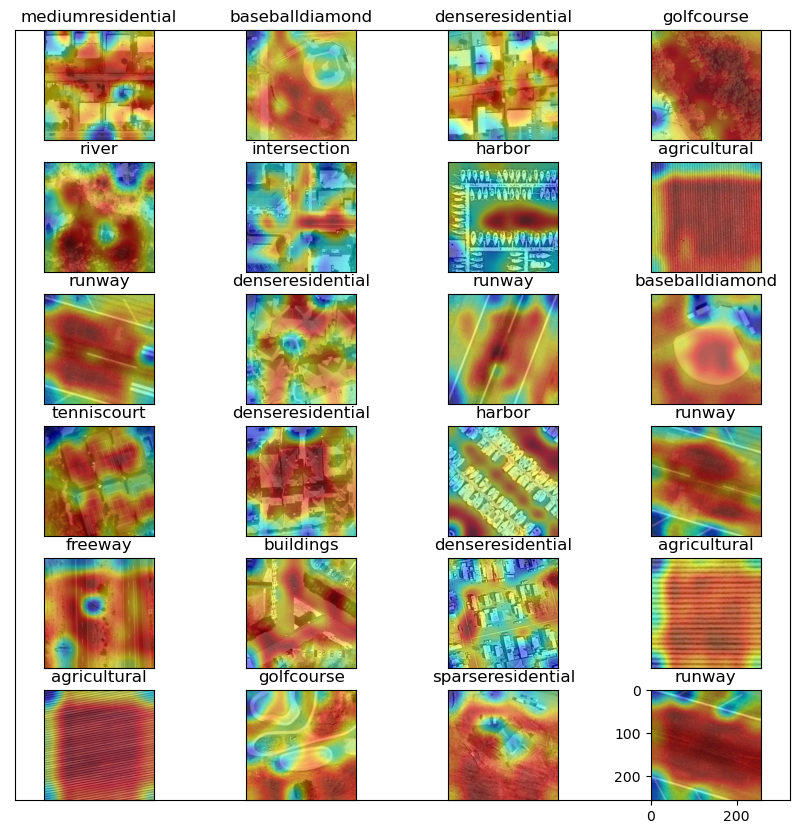

In [14]:
w = 10
h = 10
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 6
for i in range(1, columns*rows +1):
    idx = np.random.randint(len(test_dl))
    img = cam_imgs[idx]
    plt.yticks([]) 
    plt.xticks([]) 
    fig.add_subplot(rows, columns, i)
    plt.title(labels[predictions[idx]])
    plt.imshow(img)
plt.show()

In [12]:
import os
base_dir = 'results/UC'
for l in labels:
    os.system(f'mkdir -p {base_dir}/{l}')

In [13]:
for i in range(len(cam_imgs)):
    plt.imsave(f'{base_dir}/{labels[predictions[i]]}/{i}.png',cam_imgs[i])

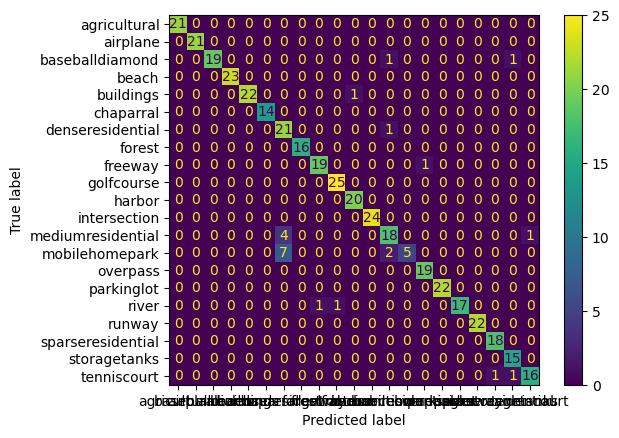

In [25]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(targets_labels,predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix,display_labels =labels)
cm_display.plot()
plt.show()